In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from multiprocessing.pool import ThreadPool
from multiprocessing import cpu_count
max_cpu = cpu_count()

# Homework (Lecture 9)
## Problem 1

### Part (a)

$X_i \sim Exp(\lambda), \lambda >0 $

$\displaystyle \sum_{i=1}^{100} \log(\lambda e^{-\lambda X_i}) \cdot 1(X_i > 0) = \sum_{i=1}^{100} \log(\lambda e^{-\lambda X_i}) = 100 log(\lambda) - \lambda \sum_{i=1}^{100} X_i$

$\frac{\partial}{\partial \lambda} ( 100 log(\lambda) - \lambda \sum_{i=1}^{100} X_i) = \frac{100}{\lambda} - \sum_i X_i \Rightarrow \hat{\lambda}^{MLE} = \displaystyle \frac{1}{\bar{X}}$

Under mild regularity conditions, the asymptotic variance of an MLE estimator can be shown to be $\sqrt{n}(\hat{\beta}_n^{MLE} - \beta) \overset{d}{\to} N(0,\Sigma^{-1})$ where $\Sigma = \displaystyle \frac{1}{I(\lambda)}$, $I(\lambda) = \displaystyle -E[\frac{\partial^2 \log{f(X;\lambda)}}{\partial \lambda^2}]$ and $f(X;\lambda) = \lambda e^{-\lambda x}$

$\displaystyle \frac{\partial}{\partial \lambda} \log{\lambda e^{-\lambda x}} = \frac{\partial}{\partial \lambda} (log{\lambda} -\lambda x) = \frac{1}{\lambda} - x \Rightarrow \frac{\partial}{\partial \lambda} (\frac{1}{\lambda} - x) = -\frac{1}{\lambda^2} \Rightarrow I(\lambda) = E[\frac{1}{\lambda^2}]$

Therefore the asymptotic variance of $\hat{\lambda}^{MLE}$ can be expressed as $E[\frac{1}{\lambda^2}]^{-1}$

### Part (b)

Given $\hat{\lambda}^{MLE}$, we can use the estimated CDF of X to find $\displaystyle P(X \le 1) = 1- e^{-\lambda \cdot 1} = 1- e^{-\hat{\lambda}^{MLE}} = 1- e^{-\frac{1}{\bar{X}}}$ = 0.918.

### Part (c)

Applying the Delta Method, since we have $\displaystyle \sqrt{n} (\frac{1}{\bar{X}} - \lambda) \overset{d}{\to} N(0, E[\frac{1}{\lambda^2}]^{-1})$, to construct a 95% CI for $P(X \le 1)$, we can show that $\displaystyle \sqrt{n} (\hat{P} - P) \overset{d}{\to} N(0, [g'(\lambda)]^2 \cdot \Sigma^{-1}) = N(0, (e^{-2 \lambda} \cdot E[\frac{1}{\lambda^2}]^{-1} )$

Now that we have the asymptotic variance of this estimator, we can construct a 95% CI: $\hat{p} \pm 1.96 \times se(\hat{p}) = 0.9179 \pm 0.0.04022$


### Part (d)

$\hat{P}(X \le 1) = 0.8 \Rightarrow \frac{1}{n} \sum_{i=1}^{100} 1(X \le 1) = 0.8$. Since the sum of Bernoulli random variables follows a binomial distribution, we know the variance is $npq = (100)(0.8)(0.2) = 16$. By the CLT, we see that $\hat{p}_n \sim N(\mu, \frac{\sigma^2}{n}) = N(0.8,0.16)$. As such, a 95% CI for $\hat{p}_n$ is: $\hat{p}_n \pm 1.96 \times se(\hat{p}_n) = 0.8 \pm 0.0784$

### Part (e)

I would trust the one from Part (d) more since it makes fewer assumptions about the true distribution of the data.

## Problem 2

### Part (a)

In [15]:
from scipy.interpolate import splrep
from scipy.interpolate import BSpline

def DGP():
    V = np.random.exponential(scale=2,size = 200)
    X = 1 + V
    epsilon = np.random.normal(0,np.sqrt(0.5),size=200)
    Y = 2 + 2 * np.log(X) + epsilon
    temp = np.sort(np.column_stack((X,Y)),axis=0)
    X, Y = temp[:,0], temp[:,1]
    
    return X, Y

def gauss_kernel(u):
    return (1/np.sqrt(2*np.pi)) * np.exp(-(u ** 2)/2)

def LL(X,Y,x,h):
    Z = np.column_stack((np.ones(X.shape[0]),X-x))
    K = np.diag(gauss_kernel((X-x)/h))
    m_vec = np.linalg.inv(Z.T @ K @ Z) @ Z.T @ K @ Y
    return m_vec[0], m_vec[1]

def NN(X,Y,x,k):
    x_norm = np.abs(X-x)
    m = (1/k) * np.sum(np.sort(np.column_stack((x_norm,Y)),axis=0)[-k:,1])
    return m

def series(X,Y,num_knots):
    t, c, k = splrep(X,Y, s=0, k=3)
    knots = np.linspace(t.min(), t.max(), num_knots)
    spline = BSpline(t, c, k, extrapolate=False)
    return spline

def loo_ll_cv(param):
    X,Y = DGP()
    err = 0
    for i in range(X.shape[0]):
        m, delt_m = LL(np.delete(X,i),np.delete(Y,i),X[i],param)
        y_hat = m + delt_m * X[i]
        err += (y_hat - Y[i]) ** 2
    return param, err

def loo_nn_cv(param):
    X,Y = DGP()
    err = 0
    for i in range(X.shape[0]):
        y_hat = NN(np.delete(X,i),np.delete(Y,i),X[i],param)
        err += (y_hat - Y[i]) ** 2
    return param, err

def cv_viz(fn,params):
    with ThreadPool(max_cpu - 1) as pool:
        output = pool.map(fn,params)
    df = pd.DataFrame(output,columns=['Parameter','Total Error'])
    plt.figure(figsize=[8,5])
    plt.scatter(x = df['Parameter'], y = df['Total Error'])
    plt.xlabel('Parameter Value')
    plt.ylabel('Total Error')

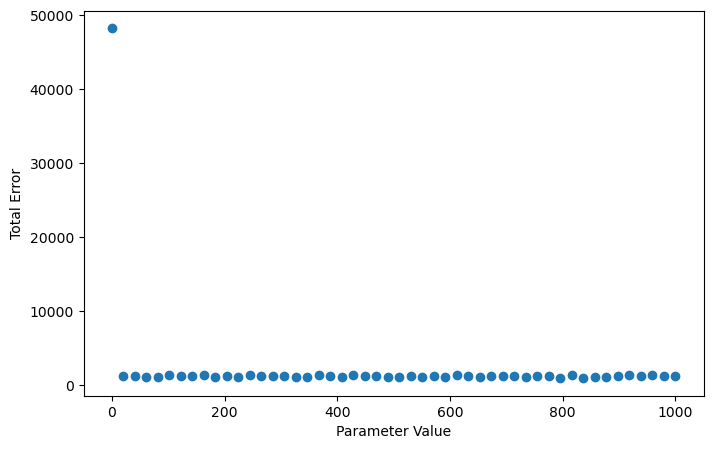

In [16]:
params = np.linspace(0.1,1000,50)
cv_viz(loo_ll_cv,params)

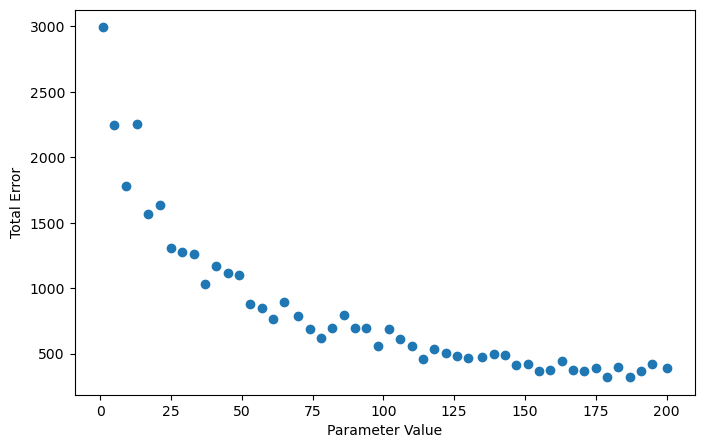

In [17]:
params = np.linspace(1,200,50,dtype=int)
cv_viz(loo_nn_cv,params)

In [ ]:
X,Y = DGP() 
# t, c, k = splrep(X,Y, s=0, k=3)
t, c, k = splrep(X,Y, k=3)
knots = np.linspace(t.min(), t.max(), 10)
spline = BSpline(t, c, k, extrapolate=False)

In [ ]:
print(X[1])
print(Y[1])
print(spline(X[1]))

In [ ]:
c.shape # c is vector of coefficients?

In [ ]:
y_new = splev(x_new, (t,c,k))

# Homework (Lecture 11)

## Problem 1

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

In [19]:
def DGP():
    X = np.concatenate((np.random.normal(2,1,size=(300,1)),
                        np.random.normal(4,1,size=(300,1))),axis=1)
    y = X.sum(axis=1) + np.random.normal(300)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, random_state=31)
    return X_train, X_test, y_train, y_test

def tree_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = DecisionTreeRegressor(ccp_alpha = param, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def rf_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = RandomForestRegressor(max_features = param, n_jobs = -1, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def boost_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = GradientBoostingRegressor(max_leaf_nodes = param, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def cv_min_param(fn,params):
    with ThreadPool(max_cpu - 1) as pool:
        output = pool.map(fn,params)
    df = pd.DataFrame(output,columns=['Parameter','MSE']).sort_values(by='MSE')
    min_param = df['Parameter'][0]
    return min_param
    # plt.figure(figsize=[8,5])
    # plt.scatter(x = df['Parameter'], y = df['MSE'])
    # plt.xlabel('Parameter Value')
    # plt.ylabel('MSE')

In [20]:
params = np.linspace(0,1,100)
tree_best = cv_min_param(tree_cv,params)
tree_best

0.0

In [21]:
params = np.linspace(1,1000,100,dtype=int)
rf_best = cv_min_param(rf_cv,params)
rf_best

1

In [22]:
params = np.linspace(2,200,100,dtype=int)
boost_best = cv_min_param(boost_cv,params)
boost_best

2

In [23]:
# training optimal models
X_train, X_test, y_train, y_test = DGP()

tree = DecisionTreeRegressor(ccp_alpha = tree_best, random_state=31).fit(X_train,y_train)
rf = RandomForestRegressor(max_features = rf_best, n_jobs = -1, random_state=31).fit(X_train,y_train)
boost = GradientBoostingRegressor(max_leaf_nodes = boost_best, random_state=31).fit(X_train,y_train)

In [24]:
print('Tree:')
print(mean_squared_error(y_test, tree.predict(X_test)))

print('RF:')
print(mean_squared_error(y_test, rf.predict(X_test)))

print('Boost:')
print(mean_squared_error(y_test, boost.predict(X_test)))

Tree:
0.2567916097552045
RF:
0.15254765570278406
Boost:
0.12052677166231912


## Problem 2

### Part (1)

In [61]:
df = pd.read_csv('penn.csv')

In [62]:
sub_df = df.loc[(df['tg'] == 0) | (df['tg'] == 4)].iloc[:,1:]

### Part (2)

In [63]:
y = np.log(sub_df['inuidur1']).to_numpy()
D = np.where(sub_df['tg']==4,1,0).reshape(sub_df.shape[0],1)
W = sub_df[['female', 'black', 'hispanic', 'othrace','agelt35', 'agegt54']].to_numpy()
X = np.concatenate((D,W),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=31)

### Part (3)

### Part (4)

Estimating $E[Y|D,W] = \beta_0 (W) + D \beta_1(W) = \beta_1 + \beta_3 W + \beta_2 D + \beta_4 D \cdot W$

In [64]:
from sklearn.linear_model import LinearRegression

In [65]:
w_train = X_train[:,1:]
d_train = X_train[:,0]
X_lr = np.concatenate((w_train,d_train.reshape(d_train.shape[0],1),np.multiply(d_train[:, np.newaxis], w_train)),axis=1)

In [66]:
reg = LinearRegression()
reg.fit(X_lr,y_train)
print(reg.intercept_)
print(reg.coef_)

2.19012858925133
[ 0.09126604 -0.29006266 -0.42020852 -0.3724348  -0.22388453  0.09206807
 -0.18419724  0.0541554   0.00745087  0.43659203 -0.14280468  0.050504
  0.1924615 ]


$\beta_1 = 2.2.19012858925133$ 

$\beta_3 = \begin{bmatrix}
                0.0.09126604  \\
                -0.29006266 \\
                -0.42020852 \\
                -0.3724348 \\
                -0.22388453  \\
                 0.09206807
            \end{bmatrix}$
            
$\beta_2 = -0.18419724$

$\beta_4 = \begin{bmatrix}
                0.0541554 \\
                0.00745087 \\
                0.43659203 \\
                -0.14280468 \\
                0.050504 \\
                0.1924615
            \end{bmatrix}$

### Part (5)


b0(w) uses subsample where everyone is control and b1(w) is where everyone is treated on Y minus the fitted values of b0(w)

In [67]:
from sklearn.model_selection import GridSearchCV

temp_df = np.concatenate((X_train,y_train.reshape(y_train.shape[0],1)),axis=1)
ctrl_df = temp_df[temp_df[:,0] == 0]
w_ctrl = ctrl_df[:,1:-1]
y_ctrl = ctrl_df[:,-1]

rf1 = RandomForestRegressor(n_jobs = -1, random_state=31)
parameters = {'max_features':np.linspace(1,6,6,dtype=int)}
b0w = GridSearchCV(rf1, parameters)
b0w.fit(w_ctrl,y_ctrl)

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=31),
             param_grid={'max_features': array([1, 2, 3, 4, 5, 6])})

In [74]:
trt_df = temp_df[temp_df[:,0] == 1]
d_trt = trt_df[:,0]
w_trt = trt_df[:,1:-1]
y_trt = trt_df[:,-1]

b0w_fitted = y_trt - d_trt * b0w.predict(w_trt)
rf2 = RandomForestRegressor(n_jobs = -1, random_state=31)
parameters = {'max_features':np.linspace(1,6,6,dtype=int)}
b1w = GridSearchCV(rf2, parameters)
b1w.fit(w_trt,b0w_fitted)

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=31),
             param_grid={'max_features': array([1, 2, 3, 4, 5, 6])})

In [75]:
w_test = X_test[:,1:]
d_test = X_test[:,0]
X_lr_test = np.concatenate((w_test,d_test.reshape(d_test.shape[0],1),np.multiply(d_test[:, np.newaxis], w_test)),axis=1)

In [77]:
rf_pred = b0w.predict(w_test) + d_test * b1w.predict(w_test)
lr_pred = reg.predict(X_lr_test)

print('Linear Functional Form Error:', mean_squared_error(y_test, lr_pred))
print('RF Error:', mean_squared_error(y_test, rf_pred))

Linear Functional Form Error: 1.4572430912505143
RF Error: 1.46095396815586


I would trust the random forest estimator from Part (5) more since it does not assume that the functional forms of $\beta_0 (W)$ and $\beta_1 (W)$ are linear.